In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# %pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Flatten,
    Concatenate,
    Multiply,
    Attention,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

2024-06-09 16:43:33.563900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [ ]:
# users.head(10)

In [ ]:
# items.head()

In [ ]:
# ratings.head()

In [4]:
# Dropping the header row
users.drop(users.index[0], inplace=True)
items.drop(items.index[0], inplace=True)
ratings.drop(ratings.index[0], inplace=True)

In [ ]:
# users.head()

In [ ]:
# items.head()

In [ ]:
# ratings.head()

In [5]:
# Merge the three forms of data
df = pd.merge(users, ratings, on="user_id")

df = pd.merge(items, df, on="isbn")
# df.head()

In [ ]:
# df.shape

In [ ]:
# df.describe()

In [ ]:
# df.info()

In [6]:
# Check for missing values
df.isnull().sum()

isbn                        0
book_title                  0
book_author                 2
year_of_publication         0
publisher                   2
img_s                       0
img_m                       0
img_l                       0
user_id                     0
location                    0
age                    277845
rating                      0
dtype: int64

In [7]:
# Drop the missing values
df.dropna(inplace=True)
df.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_s                  0
img_m                  0
img_l                  0
user_id                0
location               0
age                    0
rating                 0
dtype: int64

In [ ]:
# df.info()

In [8]:
# Convert the data types
df["user_id"] = df["user_id"].astype(int)
df["isbn"] = df["isbn"].astype(str)
df["rating"] = df["rating"].astype(float)
df["year_of_publication"] = df["year_of_publication"].astype(int)

In [9]:
# Re-index user_id and isbn
user_id_mapping = {id: idx for idx, id in enumerate(df["user_id"].unique())}
isbn_mapping = {isbn: idx for idx, isbn in enumerate(df["isbn"].unique())}

df["user_id"] = df["user_id"].map(user_id_mapping)
df["isbn"] = df["isbn"].map(isbn_mapping)

In [10]:
# # Authors with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=df['book_author'].value_counts().head(50), y=df['book_author'].value_counts().head(50).index)
# plt.xlabel("Count")
# plt.ylabel("Author")
# plt.title("Authors with Most Ratings", size=20)

In [ ]:
# ds = df["book_title"].value_counts().head(50).reset_index()
# ds.columns = ["book", "count"]
# ds.head()

In [ ]:
# # Books with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=ds['count'], y=ds['book'])
# plt.xlabel("Count")
# plt.ylabel("Book")
# plt.title("Books with Most Ratings", size=20)

# Split the dataset into training, validation, and test sets

In [11]:
# Split the dataset into training, validation, and test sets
# Splits the original dataset df into two parts: 80% of the data is assigned to train, and 20% is assigned to test.
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Splits the train dataset into two parts: 80% of the data is assigned to train, and 20% is assigned to val.
train, val = train_test_split(train, test_size=0.2, random_state=42)
# In the end, we have train: 64% of the original dataset, val: 16% of the original dataset, test: 20% of the original dataset.

In [12]:
# Extracting the input arrays
user_ids_train = train["user_id"].values
item_ids_train = train["isbn"].values
ratings_train = train["rating"].values.astype(float)
user_ids_val = val["user_id"].values
item_ids_val = val["isbn"].values
ratings_val = val["rating"].values.astype(float)

In [13]:
# Verify data types and ranges
print(user_ids_train.dtype)  # Should be integer type
print(item_ids_train.dtype)  # Should be integer type
print(ratings_train.dtype)  # Should be float type

print(
    user_ids_train.max(), len(user_id_mapping)
)  # Max value should be less than len(user_id_mapping)
print(
    item_ids_train.max(), len(isbn_mapping)
)  # Max value should be less than len(isbn_mapping)

int64
int64
float64
53887 53888
229011 229012


In [14]:
# Matrix Factorization with Neural Networks (MF-NN)
# This leverages collaborative filtering with deep learning for user-item interaction modeling.


# Define MF-NN Model
def mf_nn_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    concat = Concatenate()([user_vector, item_vector])

    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(concat)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model

In [15]:
num_users = len(user_id_mapping)
num_items = len(isbn_mapping)
# This is the dimension of the embedding vectors for both users and items.
# It determines the size of the latent factors space where users and items are projected. A higher dimension can capture more complex interactions but also increases the computational complexity and risk of overfitting.
embedding_dim = 20 #TODO: Experiment with lower number

In [16]:
# Train the MF-NN model
model_mf_nn = mf_nn_model(num_users, num_items, embedding_dim)
# model_mf_nn.summary()

13053/15067 ━━━━━━━━━━━━━━━━━━━━ 4:27 133ms/step - loss: 12.6034

In [17]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model_mf_nn.fit(
    [user_ids_train, item_ids_train],
    ratings_train,
    epochs=10,  
    batch_size=32,
    validation_data=([user_ids_val, item_ids_val], ratings_val),
    callbacks=[early_stopping],
)

Epoch 1/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2178s 144ms/step - loss: 14.3102 - val_loss: 13.1130
Epoch 2/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2074s 138ms/step - loss: 13.0606 - val_loss: 13.0880
Epoch 3/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2103s 140ms/step - loss: 12.7889 - val_loss: 12.8025
Epoch 4/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2091s 139ms/step - loss: 12.7290 - val_loss: 12.6406
Epoch 5/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2050s 136ms/step - loss: 12.6532 - val_loss: 12.8055
Epoch 6/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2075s 138ms/step - loss: 12.6912 - val_loss: 12.6421
Epoch 7/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2085s 138ms/step - loss: 12.6190 - val_loss: 12.6020
Epoch 8/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2078s 138ms/step - loss: 12.5951 - val_loss: 12.7013
Epoch 9/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2040s 135ms/step - loss: 12.5982 - val_loss: 12.6614
Epoch 10/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2051s 136ms/step - loss: 12.5918 - val_loss: 12.6857


In [79]:
model_mf_nn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 20)     │  1,077,760 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 20)     │  4,580,240 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      5,248 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,014,709 (64.91 MB)

 Trainable params: 5,671,569 (21.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,343,140 (43.27 MB)

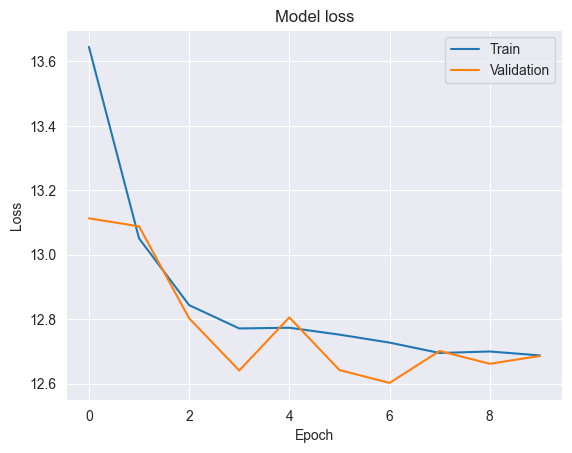

In [18]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [22]:
# Evaluate and compare performance on test set
user_ids_test = test["user_id"].astype(int).values
item_ids_test = test["isbn"].astype(int).values
ratings_test = test["rating"].astype(float).values
test_loss = model_mf_nn.evaluate(
    [user_ids_test, item_ids_test], ratings_test
)
print(f"Test Loss: {test_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 86s 18ms/step - loss: 12.5512
Test Loss: 12.608246803283691


In [24]:
# Evaluate on the validation set
val_loss = model_mf_nn.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - loss: 12.6456
Validation Loss: 12.602019309997559


In [25]:
# Optionally, predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_mf_nn.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_mf_nn.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
Prediction Validation: [[0.22642553]
 [1.1522611 ]
 [1.9160079 ]
 ...
 [3.1017416 ]
 [2.761219  ]
 [0.73361874]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step
Prediction Test: [[1.3401545]
 [1.8289626]
 [1.9587038]
 ...
 [4.219665 ]
 [2.0688624]
 [0.9706764]]
Validation RMSE: 3.4117811031498686, Test RMSE: 3.4126976483783196


# Book Recommendation

In [36]:
unique_user_ids = df["user_id"].unique()
print("Sample User IDs:")
print(unique_user_ids[:10])  # Display the first 10 user IDs


Sample User IDs:
[0 1 2 3 4 5 6 7 8 9]


In [58]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = df["user_id"].sample(1).values[0]

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val['user_id'] == user_id].index
user_val_items = val.loc[user_val_indices, 'isbn'].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val['isbn'].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_mf_nn.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame({'isbn': user_not_interacted_items, 'predicted_rating': predictions_pred.flatten()})

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(by='predicted_rating', ascending=False).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[top_n_recommendations['isbn'], ['book_title', 'book_author']]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)



2126/2126 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Top 10 Recommended Books for User 3885
                                             book_title          book_author
2661  How to Talk So Kids Will Listen and Listen So ...          Adele Faber
2015  Afrikanisches Fieber. Erfahrungen aus vierzig ...  Ryszard Kapuscinski
2096                                 The Luberon Garden   Alex Dingwall-Main
5225        Garzanti - Gli Elefanti: Creatura Di Sabbia        T Ben Jelloun
3642                                       Life Penalty         Joy Fielding
5161  Dana and the Calendar Man (Harlequin American ...        Hiram Bingham
1240  Timeless/Four Breathtaking Tales of Hearts Tha...    Linda Lael Miller
5160    Tapestry Of Fate (Harlequin Historical, No 246)        Nina Beaumont
8348  Gdje pijevac ne pjeva (Biblioteka \Zlatni paun...         Ivan Aralica
2098                                   Vieja Sirena, La   Jose Luis Sampedro


In [59]:
user_id=3885
# Get the indices of the highest rated books for a particular user from the test set
 # Specify the user ID here
user_test_indices = np.where(user_ids_test == user_id)[0]
user_test_ratings = ratings_test[user_test_indices]
highest_rated_indices = np.argsort(user_test_ratings)[-10:][::-1]  # Get indices of top 10 highest rated books

# Map indices back to book titles and authors
highest_rated_books = items.iloc[item_ids_test[user_test_indices[highest_rated_indices]]][["book_title", "book_author"]]

# Output the highest rated books for the user
print(f"Top 10 highest rated books by user {user_id}:")
for idx, (book_title, book_author) in enumerate(zip(highest_rated_books["book_title"], highest_rated_books["book_author"])):
    print(f"{idx+1}. {book_title} by {book_author}")


Top 10 highest rated books by user 3885:
1. A Hiker's Companion: 12,000 Miles of Trail-Tested Wisdom by Cindy Ross
2. Pet Sematary by Stephen King
3. The Murders of Richard III by Elizabeth Peters
4. Night Prey by Carol Davis Luce
5. Ajedrez En 20 Lecciones Para Principiantes by Lorenzo Ponce Sala
6. History of the Lewis and Clark Expedition by Meriwether Lewis
7. French Lessons: A Memoir by Alice Kaplan
8. The Cat Who Tailed a Thief by Lilian Jackson Braun
9. She'S Having His Baby (Accidental Dads) (Harlequin American Romance, 751) by Linda Randall Wisdom
10. Petites infamies by Carmen Posadas


# NCF with Attention Model

In [65]:
import random
def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seeds(42)

In [70]:
from tensorflow.keras.layers import Reshape

def ncf_attention_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    interaction = Multiply()([user_vector, item_vector])

    # Reshape interaction tensor for compatibility with Attention layer
    interaction_reshaped = Reshape((1, embedding_dim))(interaction)

    attention = Attention()([interaction_reshaped, interaction_reshaped])
    attention_vector = Flatten()(attention)

    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(attention_vector)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model


In [80]:
# Train the NCF Attention model
model_ncf_attention = ncf_attention_model(num_users, num_items, embedding_dim)
model_ncf_attention.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 20)     │  1,077,760 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 20)     │  4,580,240 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 20)        │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 20)        │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 20)        │          0 │ flatten_8[0][0],  │
│ (Multiply)          │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 20)     │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 1, 20)     │          0 │ reshape_1[0][0],  │
│ (Attention)         │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 20)        │          0 │ attention_2[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │      2,688 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,669,009 (21.63 MB)

 Trainable params: 5,669,009 (21.63 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model_ncf_attention.fit(
    [user_ids_train, item_ids_train],
    ratings_train,
    epochs=10,
    batch_size=32,
    validation_data=([user_ids_val, item_ids_val], ratings_val),
    callbacks=[early_stopping],
)

Epoch 1/10


/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


15067/15067 ━━━━━━━━━━━━━━━━━━━━ 1209s 80ms/step - loss: 15.4978 - val_loss: 14.9738
Epoch 2/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 1633s 108ms/step - loss: 14.9498 - val_loss: 14.9523
Epoch 3/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2161s 143ms/step - loss: 14.9388 - val_loss: 14.9499
Epoch 4/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 1990s 132ms/step - loss: 14.9364 - val_loss: 14.9487
Epoch 5/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2072s 137ms/step - loss: 14.9351 - val_loss: 14.9480
Epoch 6/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2086s 138ms/step - loss: 14.9342 - val_loss: 14.9475
Epoch 7/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2051s 136ms/step - loss: 14.9337 - val_loss: 14.9469
Epoch 8/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2093s 139ms/step - loss: 14.9332 - val_loss: 14.9464
Epoch 9/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2025s 134ms/step - loss: 14.9328 - val_loss: 14.9458
Epoch 10/10
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2078s 138ms/step - loss: 14.9324 - val_loss: 14.9449


In [78]:
model_ncf_attention.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 20)     │  1,077,760 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 20)     │  4,580,240 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 20)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 20)        │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 20)        │          0 │ flatten_5[0][0],  │
│ (Multiply)          │                   │            │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 20)     │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 20)     │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 20)        │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      2,688 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,007,029 (64.88 MB)

 Trainable params: 5,669,009 (21.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,338,020 (43.25 MB)

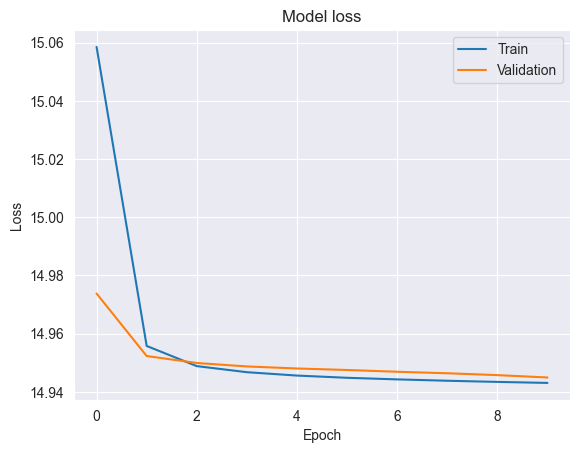

In [73]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [74]:
# Evaluate and compare performance on test set
user_ids_test = test["user_id"].astype(int).values
item_ids_test = test["isbn"].astype(int).values
ratings_test = test["rating"].astype(float).values
test_loss = model_ncf_attention.evaluate([user_ids_test, item_ids_test], ratings_test)
print(f"Test Loss: {test_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 88s 19ms/step - loss: 14.9809
Test Loss: 14.956552505493164


In [75]:
# Evaluate on the validation set
val_loss = model_ncf_attention.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - loss: 14.9468
Validation Loss: 14.944948196411133


In [76]:
# Predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_ncf_attention.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_ncf_attention.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3763/3767 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3767/3767 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step
Prediction Validation: [[2.8917146]
 [2.8917146]
 [2.8917146]
 ...
 [2.8917146]
 [2.8917146]
 [2.8917146]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step
Prediction Test: [[2.8917146]
 [2.8917146]
 [2.8917146]
 ...
 [2.8917146]
 [2.8917146]
 [2.8917146]]
Validation RMSE: 3.8652929219483054, Test RMSE: 3.86679426294512


# Book Recommendations

In [77]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val["user_id"] == user_id].index
user_val_items = val.loc[user_val_indices, "isbn"].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val["isbn"].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_ncf_attention.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame(
    {"isbn": user_not_interacted_items, "predicted_rating": predictions_pred.flatten()}
)

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(
    by="predicted_rating", ascending=False
).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[
    top_n_recommendations["isbn"], ["book_title", "book_author"]
]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)


2130/2130 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step
Top 10 Recommended Books for User 3885
                                               book_title          book_author
1                                     Classical Mythology   Mark P. O. Morford
117034  Bountiful Women: Large Women's Secrets for Liv...       Bonnie Bernell
116981                                        Kurt Cobain          Kurt Cobain
116985  La MÃ?Â©thode simple pour en finir avec la cig...           Allen Carr
116992                        Easy Cooking for One or Two        Louise Davies
116993                              Nightfire (Heartfire)           Leona Karr
116996                      Starlight (Heartfire Romance)  Gloria Dale Skinner
117005                         The Old Contemptibles-O.M.        Martha Grimes
117007                                        The Bargain         Jane Ashford
117016                                The World of Jeeves       P.G. Wodehouse
